In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

# ---- Define copper color -----
copper_color = '#B87333'

<h1>FVM</h1>

<h2>Global variables</h2>

In [2]:
# ---- Domain size -----
domain_size = 0.10

# ---- Cable specifications -----
cable_radius = 0.006
cable_diameter = cable_radius * 2
cable_x0 = 0
cable_y0 = 0

# ---- Density in wire -----
I = 20
A = np.pi * (cable_radius**2)
J_sigma = I / A

<h2>Functions</h2>

In [3]:
def read_file_msh(file):
    """
    Reads a custom .msh mesh file containing node coordinates and triangular elements.

    Parameters:
    -----------
    file : str
        Path to the mesh file. The file is expected to follow a specific format:
        - The first line contains two integers: the number of nodes (nbn) and the number of elements (nbe).
        - The next 'nbn' lines contain the coordinates (x, y) of each node.
        - The following 'nbe' lines contain the indices (1-based) of the 3 nodes forming each triangular element.

    Returns:
    --------
    tuple
        A tuple containing:
        - nbn : int
            Number of nodes.
        - nbe : int
            Number of triangular elements.
        - coord : numpy.ndarray of shape (nbn, 2)
            Coordinates of the nodes.
        - tri : numpy.ndarray of shape (nbe, 3)
            Indices of the nodes forming each triangle (0-based indexing).
    
    Notes:
    ------
    This function assumes a strict input format and performs no error checking.
    It adjusts for 1-based to 0-based indexing when reading element connectivity.
    """
    with open(file, 'r') as f:
    #---------Lecture du fichier---------
        "-----read first line-----"
        line = f.readline()
        "-----line data separation-----"
        data = line.split()
        "---retrieve each data value and convert it to an integer---"
        nbn = int(data[0])
        nbe = int(data[1])
    #-----Creating the various tables-----    
        coord = np.zeros((nbn,2) ,dtype=float)
        tri = np.zeros((nbe,3) ,dtype=int)
    #-------Initializing tables-------
        "-----coord-----"
        for i in range(nbn) :
            line = f.readline()
            data = line.split()
            for j in range(2):
                coord[i,j] = float(data[j])
        "-----tri-----"
        for i in range(nbe) :
            line = f.readline()
            data = line.split()
            for j in range(3):
                tri[i,j] = int(data[j])-1
        f.close()
        return (nbn,nbe,coord,tri)

In [4]:
def plot_mesh(nbn,nbe,coord,tri):
    """
    Plots a 2D finite element mesh (P1 triangular elements) along with a circular object (e.g., a cable).

    Parameters:
    -----------
    nbn : int
        Number of nodes in the mesh.
    nbe : int
        Number of triangular elements in the mesh.
    coord : numpy.ndarray of shape (nbn, 2)
        Array of node coordinates.
    tri : numpy.ndarray of shape (nbe, 3)
        Array of triangle connectivity, where each row contains the indices of the three nodes forming a triangle.

    Notes:
    ------
    - The function uses `matplotlib` to display the mesh with green triangle edges.
    - A circular shape (representing a cable) is also added to the plot using global variables:
        - `cable_x0`, `cable_y0` : coordinates of the cable center.
        - `cable_radius` : radius of the cable.
        - `copper_color` : color of the cable.
    - The axis is turned off for a cleaner visual of the mesh.
    - This function assumes that the above global variables are defined in the calling context.
    """
    # ---- Create figure -----
    plt.figure(figsize=(16, 16))

    # ---- Plot the cable -----
    circle = plt.Circle((cable_x0, cable_y0), cable_radius, color=copper_color, alpha=1)

    # ---- Add cable to the plot -----
    ax = plt.gca()
    ax.add_patch(circle)
    
    #-------Tracé du maillage-------
    plt.triplot(coord[:,0],coord[:,1],tri,'g-',linewidth=0.6)
    plt.title(["Finite Elements type P1 mesh ("+str(nbe)+" triangles, "+str(nbn)+" nodes)"])
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.axis('off')
    
    plt.show()

In [5]:
def barycenter(nbe):
    """
    Computes the barycenters (geometric centers) of triangular elements in a 2D mesh.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    center : numpy.ndarray of shape (nbe, 2)
        Coordinates of the barycenter of each triangle.

    Notes:
    ------
    - This function assumes that the global variables `coord` and `tri` are defined:
        - `coord` : array of node coordinates, shape (nbn, 2)
        - `tri` : array of triangle node indices, shape (nbe, 3)
    - The barycenter of each triangle is computed as the mean of the coordinates of its three vertices.
    """
    center = np.zeros((nbe, 2), dtype=float)
    for i in range(nbe):
        center[i, 0] = np.mean(coord[tri[i], 0])
        center[i, 1] = np.mean(coord[tri[i], 1])
    return center

In [6]:
def build_edge_dict(nbe):
    """
    Builds a dictionary mapping each unique edge in the mesh to the list of elements (triangles) that share it.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    edge_dict : dict
        A dictionary where:
            - keys are tuples of node indices representing undirected edges (sorted in ascending order),
            - values are lists of indices of the triangles that share each edge.

    Notes:
    ------
    - This function assumes the global variable `tri` is defined:
        - `tri` : numpy.ndarray of shape (nbe, 3), containing the node indices for each triangle.
    - Each triangle contributes three edges.
    - Shared edges (between two adjacent triangles) will appear in two triangle entries in the dictionary.
    """
    edge_dict = {}
    for i in range(nbe):
        for j in range(3):
            node1, node2 = tri[i, j], tri[i, (j + 1) % 3]
            edge = tuple(sorted([node1, node2]))
            if edge in edge_dict:
                edge_dict[edge].append(i)
            else:
                edge_dict[edge] = [i]
    return edge_dict

In [7]:
def search_neighbors(nbe):
    """
    Identifies the neighboring triangle for each edge of every triangle in a 2D mesh.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    neighbors : numpy.ndarray of shape (nbe, 3)
        Array where each row corresponds to a triangle, and each column indicates the index
        of the neighboring triangle across one of its three edges.
        - If an edge lies on the boundary (i.e., has no neighbor), the value is -1.

    Notes:
    ------
    - This function assumes the global variables `tri` and `edge_dict` are defined:
        - `tri` : numpy.ndarray of shape (nbe, 3), with node indices for each triangle.
        - `edge_dict` : dict mapping sorted node pairs (edges) to lists of triangle indices sharing the edge.
    - The edge ordering follows the local ordering of triangle vertices:
        Edge 0: (node0, node1), Edge 1: (node1, node2), Edge 2: (node2, node0)
    """
    neighbors = -np.ones((nbe, 3), dtype=int)
    for i in range(nbe):
        for j in range(3):
            node1, node2 = tri[i, j], tri[i, (j + 1) % 3]
            edge = tuple(sorted([node1, node2]))
            neighbor_indices = [idx for idx in edge_dict[edge] if idx != i]
            if neighbor_indices:
                neighbors[i, j] = neighbor_indices[0]
    return neighbors

In [8]:
def midpoint(A, B):
    """
    Computes the midpoint between two nodes in a 2D mesh.

    Parameters:
    -----------
    A : int
        Index of the first node.
    B : int
        Index of the second node.

    Returns:
    --------
    numpy.ndarray of shape (2,)
        Coordinates of the midpoint between nodes A and B.

    Notes:
    ------
    - This function assumes the global variable `coord` is defined:
        - `coord` : numpy.ndarray of shape (nbn, 2), containing the coordinates of all nodes.
    - The midpoint is calculated as the average of the coordinates of the two nodes.
    """
    return (coord[A] + coord[B]) / 2.0

In [9]:
def compute_normal(A, B, M, G):
    """
    Computes the (unnormalized) outward-pointing normal vector to the edge AB, oriented toward the triangle center G.

    Parameters:
    -----------
    A : int
        Index of the first node defining the edge.
    B : int
        Index of the second node defining the edge.
    M : numpy.ndarray of shape (2,)
        Coordinates of the midpoint of the edge AB.
    G : numpy.ndarray of shape (2,)
        Coordinates of the barycenter (center) of the triangle that owns the edge.

    Returns:
    --------
    normal : numpy.ndarray of shape (2,)
        Outward normal vector (not normalized) to the edge AB, oriented toward the triangle's exterior.

    Notes:
    ------
    - This function assumes the global variable `coord` is defined:
        - `coord` : numpy.ndarray of shape (nbn, 2), containing the coordinates of all nodes.
    - The normal vector is computed as perpendicular to the edge AB, and its direction is chosen
      such that it points *away* from the triangle (based on the dot product with the vector from midpoint M to center G).
    - The returned normal is not normalized (its length equals the edge length).
    - To obtain a unit vector, uncomment the normalization line:
        `normal /= np.linalg.norm(normal)`
    """
    normal = np.zeros(2)
    normal[0] = -(coord[B, 1] - coord[A, 1])
    normal[1] = coord[B, 0] - coord[A, 0]
    #normal /= np.linalg.norm(normal)
    vector_to_center = G - M
    if np.dot(normal, vector_to_center) > 0:
        normal = -normal
    return normal

In [10]:
def compute_distance(nbe):
    """
    Computes the distances used for finite volume or edge-based schemes between triangle centers and either:
    - the midpoint of an edge (if the edge is on the boundary), or
    - the center of the neighboring triangle (if the edge is internal).

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    distance : numpy.ndarray of shape (nbe, 3)
        Array where each entry [i, j] contains the distance associated with the j-th edge of triangle i,
        based on whether the edge is a boundary or shared edge.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `tri` : numpy.ndarray of shape (nbe, 3), triangle connectivity.
        - `neighbors` : numpy.ndarray of shape (nbe, 3), indices of neighboring triangles per edge (-1 if boundary).
        - `center` : numpy.ndarray of shape (nbe, 2), barycenters of triangles.
        - `midpoint(A, B)` : function returning the coordinates of the midpoint between nodes A and B.
    - For boundary edges, the distance is computed from the triangle center to the edge midpoint.
    - For interior edges, the distance is computed between the centers of the two adjacent triangles.
    """
    distance = np.zeros((nbe, 3), dtype=float)
    for i in range(nbe):
        for j in range(3):
            A, B = tri[i, j], tri[i, (j + 1) % 3]
            M = midpoint(A, B)
            neighbor_idx = neighbors[i, j]
            if neighbor_idx == -1:
                distance[i, j] = np.linalg.norm(M - center[i])
            else:
                distance[i, j] = np.linalg.norm(center[neighbor_idx] - center[i])
    return distance

In [11]:
def compute_eta(nbe):
    """
    Computes the normal vectors (eta) associated with each edge of each triangle in a 2D mesh.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    eta : numpy.ndarray of shape (nbe, 3, 2)
        Array where eta[i, j] contains the 2D normal vector (not normalized) for the j-th edge of triangle i.
        Each normal is oriented outward with respect to the triangle.

    Notes:
    ------
    - This function assumes the following global variables and functions are available:
        - `tri` : numpy.ndarray of shape (nbe, 3), triangle vertex indices.
        - `center` : numpy.ndarray of shape (nbe, 2), barycenters of triangles.
        - `coord` : numpy.ndarray of shape (nbn, 2), node coordinates.
        - `midpoint(A, B)` : function computing the coordinates of the midpoint of edge AB.
        - `compute_normal(A, B, M, G)` : function computing the outward normal to edge AB based on midpoint M and triangle center G.
    - The normal vector is computed for each edge of every triangle and oriented so that it points outward from the triangle.
    - The returned normals are not normalized. You can normalize them inside `compute_normal` if needed.
    """
    eta = np.zeros((nbe, 3, 2), dtype=float)
    for i in range(nbe):
        for j in range(3):
            A, B = tri[i, j], tri[i, (j + 1) % 3]
            M = midpoint(A, B)
            eta[i, j] = compute_normal(A, B, M, center[i])
    return eta

In [12]:
def measT(A,B,C):
    """
    Computes the area of a triangle defined by three 2D points A, B, and C.

    Parameters:
    -----------
    A, B, C : array-like of length 2
        Coordinates of the triangle vertices in 2D space, e.g., [x, y].

    Returns:
    --------
    float
        The absolute area of the triangle formed by points A, B, and C.

    Notes:
    ------
    - The formula used is based on the determinant method (half the absolute value of the cross product).
    - The area is always positive regardless of the orientation of the points.
    """
    x1 = C[0] - A[0]
    x2 = C[0] - B[0]
    y1 = C[1] - A[1]
    y2 = C[1] - B[1]      
    return(0.5 * abs((x1*y2)-(y1*x2)))

In [13]:
def compute_area(nbe):
    """
    Computes the area of each triangular element in a 2D mesh.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    area : numpy.ndarray of shape (nbe,)
        Array containing the area of each triangle.

    Notes:
    ------
    - This function assumes the global variables `tri` and `coord` are defined:
        - `tri` : numpy.ndarray of shape (nbe, 3), triangle vertex indices.
        - `coord` : numpy.ndarray of shape (nbn, 2), coordinates of mesh nodes.
    - Uses the function `measT(A, B, C)` to compute the area of individual triangles.
    """
    area = np.zeros(nbe, dtype=float)
    for i in range(nbe):
        I1, I2, I3 = tri[i]
        M1, M2, M3 = coord[I1], coord[I2], coord[I3]
        area[i] = measT(M1,M2,M3)
    return area

In [14]:
def compute_density(point):
    """
    Computes the current density at a given point based on its position relative to a circular cable.

    Parameters:
    -----------
    point : array-like of length 2
        Coordinates [x, y] of the point where the density is to be evaluated.

    Returns:
    --------
    float
        Current density at the given point. Returns `J_sigma` if the point lies within the cable,
        otherwise returns 0.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `cable_x0`, `cable_y0` : float, coordinates of the cable center.
        - `cable_radius` : float, radius of the cable.
        - `J_sigma` : float, current density inside the cable.
    - The function returns a non-zero density only inside the circular cable region.
    """
    # ---- Distance to cables centers -----
    distance_to_cable = np.sqrt((point[0] - cable_x0)**2 + (point[1] - cable_y0)**2)

    # ---- Check spot -----
    if distance_to_cable <= cable_radius:
        return J_sigma
    else:
        return 0

In [15]:
def vector_density(nbe):
    """
    Computes the current density vector J for each triangular element in the mesh.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    J : numpy.ndarray of shape (nbe,)
        Array where each entry J[i] is the current density at the barycenter of triangle i.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `center` : numpy.ndarray of shape (nbe, 2), containing the barycenters of the mesh triangles.
        - `compute_density(point)` : function that computes the current density at a given 2D point.
    - Typically, the density is non-zero only within a specified region (e.g., inside a circular cable).
    """
    J = np.zeros(nbe, dtype=float)
    for i in range(nbe):
        J[i] = compute_density(center[i])
    return J

<h2> Initialization </h2>

In [16]:
file = '1_wire.msh'
[nbn,nbe,coord,tri] = read_file_msh(file)
center = barycenter(nbe)
edge_dict = build_edge_dict(nbe)
neighbors = search_neighbors(nbe)
distance = compute_distance(nbe)
eta = compute_eta(nbe)
area = compute_area(nbe)

In [17]:
Hx_vector = np.zeros(nbe)
Hy_vector = np.zeros(nbe)
H_vector = np.zeros(2*nbe)
Assemble_Hx = np.zeros((nbe, nbe))
Assemble_Hy = np.zeros((nbe, nbe))
J_vector = vector_density(nbe)

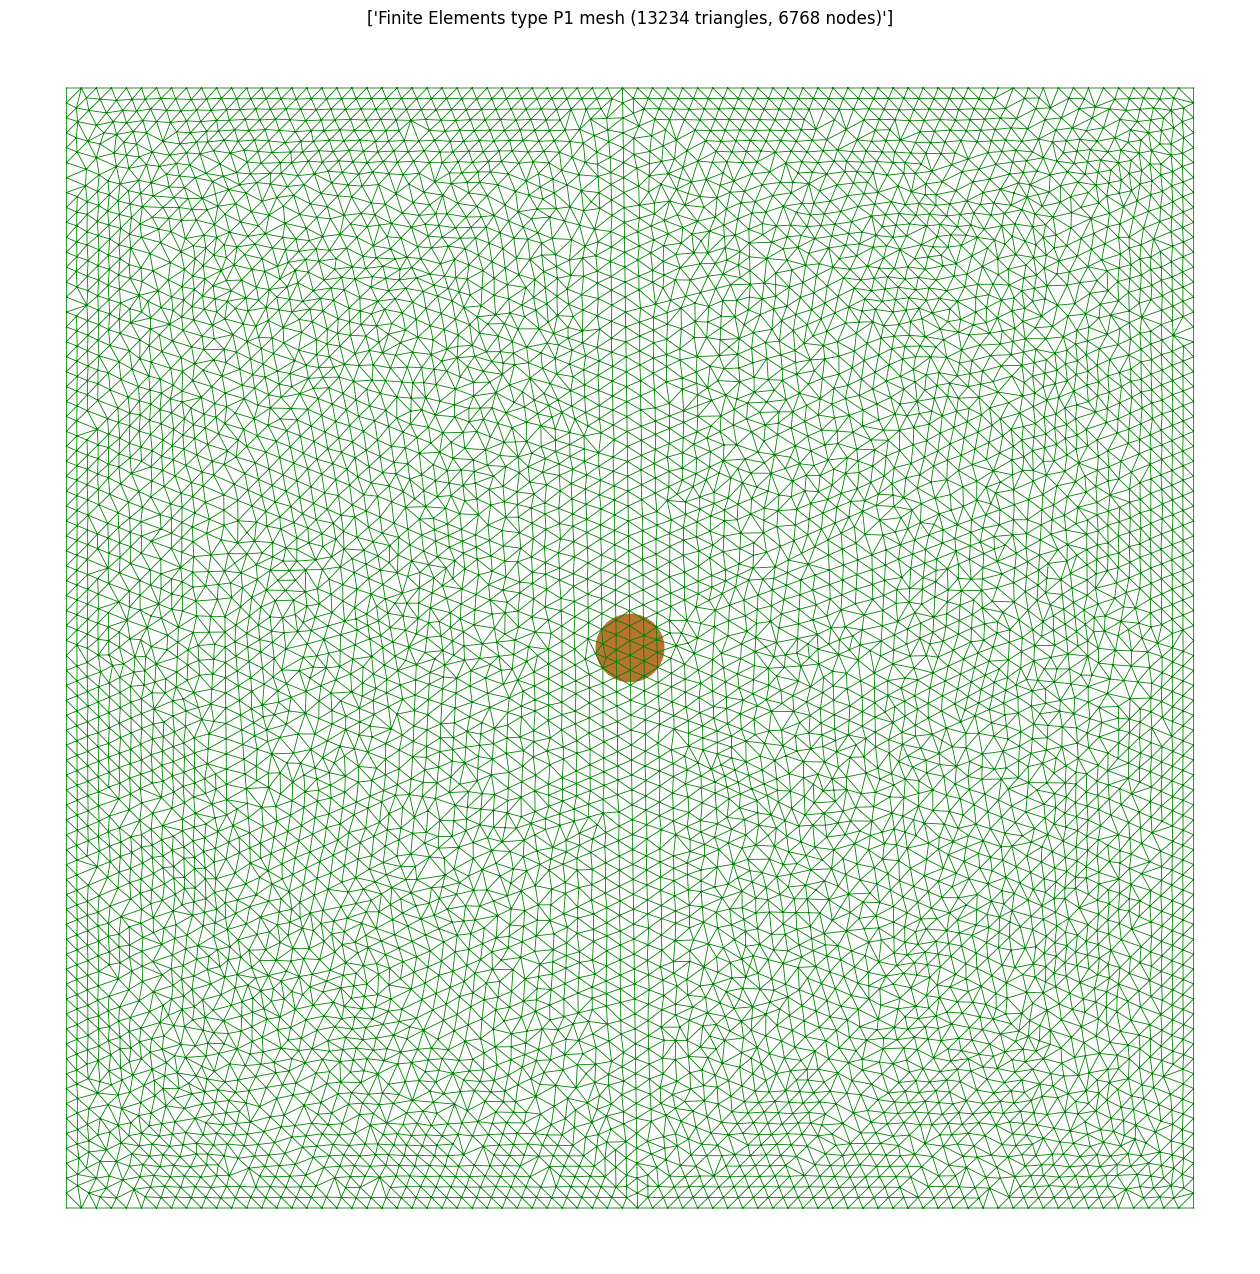

In [18]:
plot_mesh(nbn,nbe,coord,tri)

<h2> FVM computation</h2>

In [19]:
# ---- Assembly matrix A_Hy -----
for i in range(nbe):
    for j in range(3):
        if neighbors[i,j] == -1:
            Assemble_Hy[i, i] += (1 / area[i]) * eta[i, j, 0]
        else:
            value = (1 / area[i]) * (eta[i, j, 0] / 2)
            Assemble_Hy[i, i] += value
            Assemble_Hy[i, neighbors[i, j]] += value

# ---- Assembly matrix A_Hx -----
for i in range(nbe):
    for j in range(3):
        if neighbors[i,j] == -1:
            Assemble_Hx[i, i] += (1 / area[i]) * eta[i, j, 1]
        else:
            value = (1 / area[i]) * (eta[i, j, 1] / 2)
            Assemble_Hx[i, i] += value
            Assemble_Hx[i, neighbors[i, j]] += value

In [20]:
# ---- Concatenate A -----
Assemble_H = np.hstack((Assemble_Hy, -Assemble_Hx))

In [21]:
# ---- SVD decomposition on dense matrix -----
U, S, VT = np.linalg.svd(Assemble_H, full_matrices=False)

In [22]:
# ---- Pseudo-inverse computation -----
S_inv = np.diag(1 / S)

In [23]:
Assemble_H_pseudo_inv = VT.T @ S_inv @ U.T  # Complete pseudo-inverse computation

In [24]:
# ---- Solve equation Ah + j = 0 => h = -A_pseudo_inv @ j -----
H_vector = Assemble_H_pseudo_inv @ J_vector

In [25]:
# ---- Hx and Hy extraction -----
Hy = H_vector[0 : nbe]
Hx = H_vector[nbe :]

<h2> Visualization </h2>

In [26]:
# ---- Prepare data for quiver plot -----
# Extract x and y coordinates of the centers
X = center[:, 0]
Y = center[:, 1]

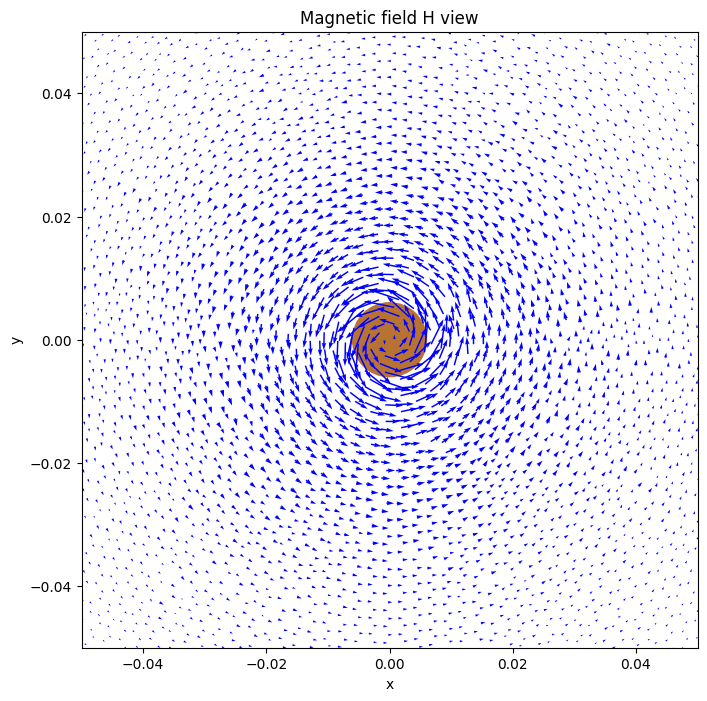

In [27]:
# ---- Create figure -----
plt.figure(figsize=(8, 8))

# ---- Plot the cable -----
circle = plt.Circle((cable_x0, cable_y0), cable_radius, color=copper_color, alpha=1)

# ---- Add cable to the plot -----
ax = plt.gca()
ax.add_patch(circle)

# ---- Plot magnetic field -----
plt.quiver(X, Y, Hx, Hy, color='blue')

# ---- Set labels -----
plt.title('Magnetic field H view')
plt.xlabel('x')
plt.ylabel('y')

# ---- Set equal aspect ratio -----
ax.set_aspect('equal', 'box')

# ---- Set plot limits to ensure the entire domain is visible -----
plt.xlim(-domain_size/2, domain_size/2)
plt.ylim(-domain_size/2, domain_size/2)

# ---- figure display -----
plt.show()

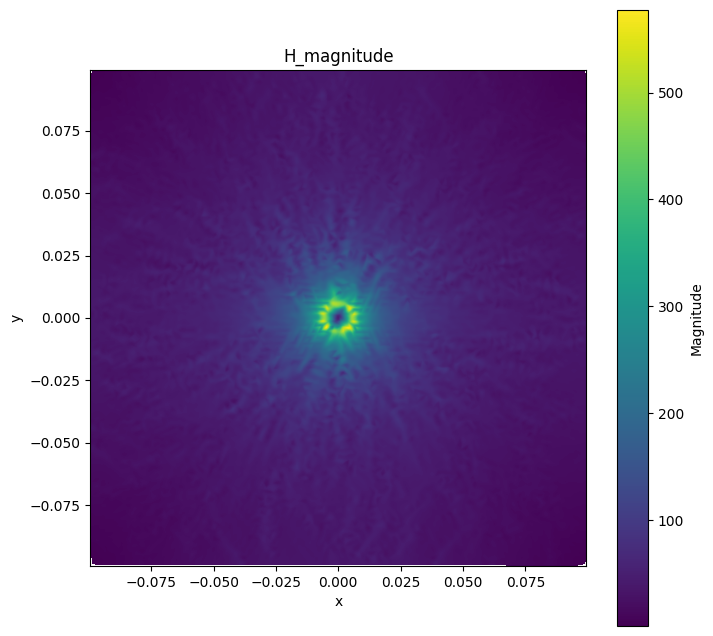

In [28]:
# Calcul de la magnitude du champ magnétique
H_magnitude = np.sqrt(Hx**2 + Hy**2)

# Définir une grille 2D pour l'interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(X.min(), X.max(), 1000),
    np.linspace(Y.min(), Y.max(), 1000)
)

# Interpolation des données
grid_z = griddata((X, Y), H_magnitude, (grid_x, grid_y), method='cubic')
#grid_z = griddata((X, Y), H_magnitude, (grid_x, grid_y), method='linear')

# Affichage de la magnitude
plt.figure(figsize=(8, 8))
plt.imshow(grid_z.T, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('H_magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<h1> State Representation </h1>

<h2> Global variables </h2>

In [29]:
mu_0 = 4*np.pi*1e-7
mu_copper = 1

sigma_air = 1e-15
sigma_copper = 59e6 

epsilon_0 = 8.85e-12
epsilon_copper = 0

<h2> Functions </h2>

In [30]:
def compute_permeability(point):
    """
    Computes the magnetic reluctivity (1 / permeability) at a given 2D point 
    depending on whether it lies inside a circular copper cable or in free space.

    Parameters:
    -----------
    point : array-like of length 2
        Coordinates [x, y] of the point where the reluctivity is to be evaluated.

    Returns:
    --------
    float
        Magnetic reluctivity at the point:
        - 1 / mu_copper if the point is inside the cable,
        - 1 / mu_0 (free space reluctivity) otherwise.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `cable_x0`, `cable_y0` : float, coordinates of the cable center.
        - `cable_radius` : float, radius of the cable.
        - `mu_copper` : float, magnetic permeability of copper.
        - `mu_0` : float, magnetic permeability of free space.
    """
    # ---- Distance to cable center -----
    distance_to_cable = np.sqrt((point[0] - cable_x0)**2 + (point[1] - cable_y0)**2)

    # ---- Check spot -----
    if distance_to_cable <= cable_radius:
        return 1/mu_copper
    else:
        return 1/mu_0

In [31]:
def vector_permeability(nbe):
    """
    Computes the magnetic reluctivity vector (1 / permeability) for each triangular element 
    in the mesh, based on the location of its barycenter.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    mu : numpy.ndarray of shape (nbe,)
        Array where mu[i] is the magnetic reluctivity at the barycenter of triangle i.

    Notes:
    ------
    - This function assumes the global variable `center` is defined:
        - `center` : numpy.ndarray of shape (nbe, 2), barycenters of the triangles.
    - Uses `compute_permeability(point)` to evaluate reluctivity at each center.
    """
    mu = np.zeros(nbe, dtype=float)
    for i in range(nbe):
        mu[i] = compute_permeability(center[i])
    return mu

In [32]:
def compute_permitivity(point):
    """
    Computes the electric permittivity at a given 2D point, depending on whether
    the point lies inside a circular copper cable or in free space.

    Parameters:
    -----------
    point : array-like of length 2
        Coordinates [x, y] of the point where the permittivity is to be evaluated.

    Returns:
    --------
    float
        Electric permittivity at the given point:
        - `epsilon_copper` if the point is inside the cable,
        - 1 / `epsilon_0` (inverse of vacuum permittivity) otherwise.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `cable_x0`, `cable_y0` : float, coordinates of the cable center.
        - `cable_radius` : float, radius of the cable.
        - `epsilon_copper` : float, electric permittivity of copper.
        - `epsilon_0` : float, vacuum permittivity (usually defined as a constant).
    """
    # ---- Distance to cable center -----
    distance_to_cable = np.sqrt((point[0] - cable_x0)**2 + (point[1] - cable_y0)**2)

    # ---- Check spot -----
    if distance_to_cable <= cable_radius:
        return epsilon_copper
    else:
        return 1/epsilon_0

In [33]:
def vector_permitivity(nbe):
    """
    Computes the electric permittivity vector for each triangular element in the mesh,
    evaluated at the barycenter of each triangle.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    epsilon : numpy.ndarray of shape (nbe,)
        Array where epsilon[i] is the electric permittivity at the barycenter of triangle i.

    Notes:
    ------
    - This function assumes the global variable `center` is defined:
        - `center` : numpy.ndarray of shape (nbe, 2), barycenters of the triangles.
    - Uses `compute_permitivity(point)` to evaluate permittivity at each center.
    """
    epsilon = np.zeros(nbe, dtype=float)
    for i in range(nbe):
        epsilon[i] = compute_permitivity(center[i])
    return epsilon

In [34]:
def compute_conductivity(point):
    """
    Computes the electrical conductivity at a given 2D point, depending on whether
    the point lies inside a circular copper cable or in the surrounding air.

    Parameters:
    -----------
    point : array-like of length 2
        Coordinates [x, y] of the point where the conductivity is to be evaluated.

    Returns:
    --------
    float
        Electrical conductivity at the given point:
        - `sigma_copper` if the point is inside the cable,
        - `sigma_air` otherwise.

    Notes:
    ------
    - This function assumes the following global variables are defined:
        - `cable_x0`, `cable_y0` : float, coordinates of the cable center.
        - `cable_radius` : float, radius of the cable.
        - `sigma_copper` : float, electrical conductivity of copper.
        - `sigma_air` : float, electrical conductivity of air (usually close to 0).
    """
    # ---- Distance to cable center -----
    distance_to_cable = np.sqrt((point[0] - cable_x0)**2 + (point[1] - cable_y0)**2)

    # ---- Check spot -----
    if distance_to_cable <= cable_radius:
        return sigma_copper
    else:
        return sigma_air

In [35]:
def vector_conductivity(nbe):
    """
    Computes the electrical conductivity vector for each triangular element in the mesh,
    evaluated at the barycenter of each triangle.

    Parameters:
    -----------
    nbe : int
        Number of triangular elements in the mesh.

    Returns:
    --------
    sigma : numpy.ndarray of shape (nbe,)
        Array where sigma[i] is the electrical conductivity at the barycenter of triangle i.

    Notes:
    ------
    - This function assumes the global variable `center` is defined:
        - `center` : numpy.ndarray of shape (nbe, 2), barycenters of the triangles.
    - Uses `compute_conductivity(point)` to evaluate conductivity at each center.
    """
    sigma = np.zeros(nbe, dtype=float)
    for i in range(nbe):
        sigma[i] = compute_conductivity(center[i])
    return sigma